In [211]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from library import plots
import math
from scipy import interpolate
from cellpose import plot, utils
import os
from scipy.spatial import ConvexHull
percent_of_side = 0.10

## Read in Data

Note: The two channel images seem to have an offset. This messed up the analysis. I had to manually adjust the offset in the preprocessing step.

In [192]:
_, blue = cv2.imreadmulti('data/Blue-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, red = cv2.imreadmulti('data/Red-34a-dbl_0002.tiff', [], cv2.IMREAD_UNCHANGED)
_, composite = cv2.imreadmulti('data/Composite-34a-dbl_0002.tiff', [], cv2.IMREAD_GRAYSCALE)

rows,cols = red[42].shape
M = np.float32([[1,0,5],[0,1,-3]])

# List of tuples of the form (blue, red, composite) 
red_offset = [cv2.warpAffine(red[i],M,(cols,rows)) for i in range(len(red))]
blue_composite = [(blue[i], composite[i]) for i in range(len(composite))]
red_composite = [(red_offset[i], composite[i]) for i in range(len(composite))]
red_blue_composite = [(red_offset[i], blue[i], composite[i]) for i in range(len(composite))]

## Create segmentations of blue and red

In [214]:
# RUN CELLPOSE

import os
from cellpose import models, io
from cellpose import plot

# DEFINE CELLPOSE MODEL
model = models.CellposeModel(gpu=False, model_type='CPx')
folders = ['red','blue']
for folder in folders:
    if not os.path.exists(folder):
        os.mkdir(folder)

chan = [0,0]
for idx,img_red in enumerate(red_offset):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        masks, flows, diams = model.eval(img_red, diameter=45.6,flow_threshold=0.4, channels=chan)
        io.masks_flows_to_seg(img_red, masks, flows, 45.6, f'red/{idx}', chan)

chan = [0,0]
for idx,img_blue in enumerate(blue):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        masks, flows, diams = model.eval(img_blue, diameter=45.6,flow_threshold=0.4, channels=chan)
        io.masks_flows_to_seg(img_blue, masks, flows, 45.6, f'blue/{idx}', chan)

## Example segmentation images

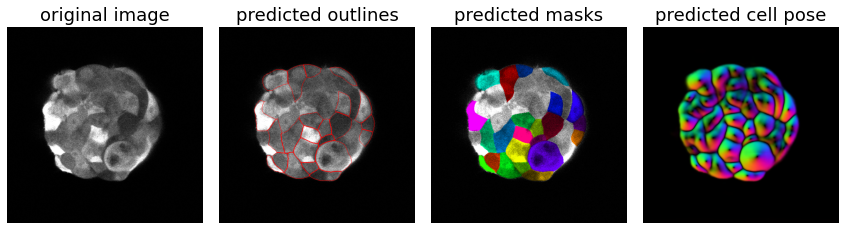

In [205]:
font = {
    'weight' : 'normal',
    'size'   : 15 
    }
plt.rc('font', **font)
img_blue = blue[54]
img_red = red[54]
masks1, flows1, styles1 = model.eval(img_blue, diameter=45.6,flow_threshold=0.4, channels=chan)
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_blue, masks1, flows1[0], channels=chan)
plt.tight_layout()
plt.show()

## Use segmentations to create plots

#### Find limits of data


In [196]:
def get_cell_masks(img, outlines):
    masked_imgs= []
    for o in outlines:
        x = o[:,0]
        y = o[:,1]
        x = np.r_[x, x[0]]
        y = np.r_[y, y[0]]
        tck, u = interpolate.splprep([x, y], s=0, per=True)
        xi, yi = interpolate.splev(np.linspace(0, 1, 1000), tck)
        contour = np.array([[xii, yii] for xii, yii in zip(xi.astype(int), yi.astype(int))])
        mask    = np.zeros_like(img)
        cv2.fillPoly(mask, pts=[contour], color=(255, 255, 255))
        masked_img = cv2.bitwise_and(img, mask)
        masked_imgs.append(masked_img)
    return masked_imgs

def get_pixel_intensities(img, pts):
    pixel_intensities = img[pts[0], pts[1]] 
    return pixel_intensities

def xy_lim(file):
    # red limit
    dat = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
    img = dat['img']
    outlines = utils.outlines_list(dat['masks'])
    masked_imgs_red = get_cell_masks(img,outlines)
    means_red = np.array([np.mean(get_pixel_intensities(img, np.where(masked_img > 0))) for masked_img in masked_imgs_red])

    # blue limit
    dat = np.load(f'blue/{file}_seg.npy', allow_pickle=True).item()
    img = dat['img']
    masked_imgs_blue = get_cell_masks(img,outlines)
    means_blue = np.array([np.mean(get_pixel_intensities(img, np.where(masked_img > 0))) for masked_img in masked_imgs_blue])

    return max((np.max(means_red),np.max(means_blue)))

max_limit = 0
for idx in range(len(blue)):
    if idx >= len(red)*percent_of_side and idx <= len(red)*(1-percent_of_side):
        max_limit = max(max_limit, xy_lim(f'{idx}'))
print(max_limit)

3313.4390539721044


#### Scatter Plot

In [220]:
def blue_red_cell_scatter(file,data):
    font = {
        'weight' : 'bold',
        'size'   : 22
        }
    plt.rc('font', **font)
    dat = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
    # red limit
    dat = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
    img = dat['img']
    outlines = utils.outlines_list(dat['masks'])
    masked_imgs_red = get_cell_masks(img,outlines)
    means_red = np.array([np.mean(get_pixel_intensities(img, np.where(masked_img > 0))) for masked_img in masked_imgs_red])

    # blue limit
    dat = np.load(f'blue/{file}_seg.npy', allow_pickle=True).item()
    img = dat['img']
    masked_imgs_blue = get_cell_masks(img,outlines)
    means_blue = np.array([np.mean(get_pixel_intensities(img, np.where(masked_img > 0))) for masked_img in masked_imgs_blue])

    # plot image with masks overlaid
    mask_RGB = plot.mask_overlay(dat['img'], dat['masks'])

    # plot image with outlines overlaid in red (this is for blue segmentation)
    outlines = utils.outlines_list(dat['masks'])
    plt.figure(figsize=(12,10))
    plt.imshow(dat['img'])
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='r')
    
    # scatter plot
    plt.plot(means_red, means_blue, 'o')
    plt.xlabel('Mean mKate2')
    plt.ylabel('Mean CFP')
    plt.gca().set_ylim(-0.5, data['lim'])
    plt.gca().set_xlim(-0.5, data['lim'])
    plt.title(f'Mean CFP vs Mean mKate2 Intensity at frame {file}')

    # Convex Hull around the data points
    points = np.array([means_red, means_blue]).T
    hull = ConvexHull(points)
    plt.plot(np.append(points[hull.vertices,0],points[hull.vertices[0],0]), np.append(points[hull.vertices,1],points[hull.vertices[0],1]), 'r--', lw=2)

    # intrinsic and extrinsic noise
    points_blue = means_blue
    points_red = means_red
    points_blue_mean = np.mean(points_blue)
    points_red_mean = np.mean(points_red)
    intrinsic = (1/len(points_blue))*sum([0.5*(blue - red)**2 for blue, red in zip(points_blue, points_red)])/(points_blue_mean * points_red_mean)
    extrinsic = (1/len(points_blue))*sum([blue*red - points_red_mean*points_blue_mean for blue, red in zip(points_blue, points_red)])/(points_blue_mean * points_red_mean)
    data["intrinsics"].append(intrinsic)
    data["extrinsics"].append(extrinsic)
    data["cv_red"].append(np.std(means_red)/np.mean(means_red))
    data["cv_blue"].append(np.std(means_blue)/np.mean(means_blue))

In [221]:
name_of_file = 'plots/cell_scatter_wimg.gif'
plotting_function = blue_red_cell_scatter
intrinsics = []
extrinsics = []
cv_red = []
cv_blue = []
data = {}
data['intrinsics'] = intrinsics
data['extrinsics'] = extrinsics
data["cv_red"] = cv_red
data["cv_blue"] = cv_blue
data["lim"] = max_limit
plots.create_gif(name_of_file, plotting_function, percent_of_side, red, data, no_images=True)

Text(0.5, 1.0, 'Intrinsic Noise vs Frame')

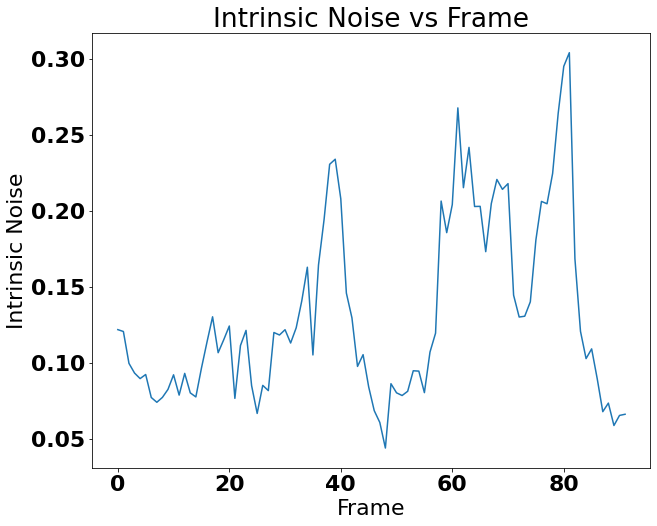

In [210]:
# Plot intrinsic noise
plt.figure(figsize=(10,8))
plt.plot(data['intrinsics'])
plt.xlabel('Frame')
plt.ylabel('Intrinsic Noise')
plt.title('Intrinsic Noise vs Frame')

Text(0.5, 1.0, 'Extrinsic Noise vs Frame')

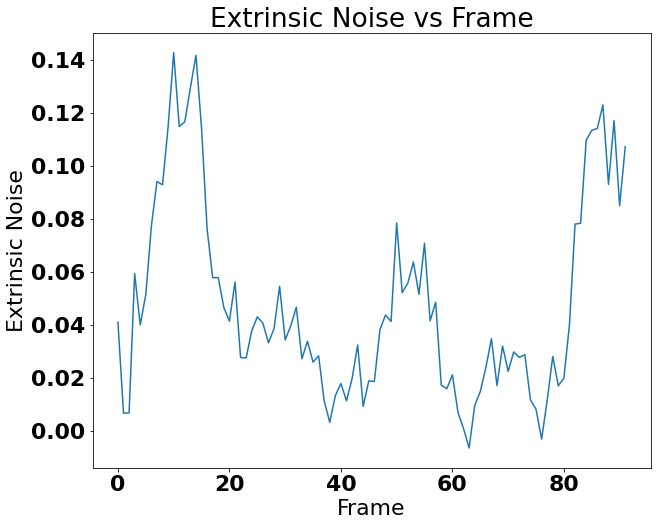

In [200]:
# Plot extrinsic noise
plt.figure(figsize=(10,8))
plt.plot(data['extrinsics'])
plt.xlabel('Frame')
plt.ylabel('Extrinsic Noise')
plt.title('Extrinsic Noise vs Frame')

Text(0.5, 1.0, 'CFP CV vs Frame')

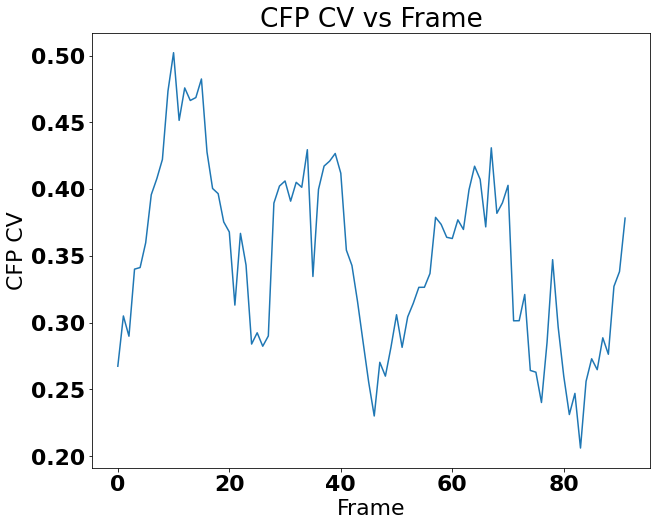

In [201]:
# Plot blue CV noise
plt.figure(figsize=(10,8))
plt.plot(data['cv_blue'])
plt.xlabel('Frame')
plt.ylabel('CFP CV')
plt.title('CFP CV vs Frame')

Text(0.5, 1.0, 'mKate2 CV vs Frame')

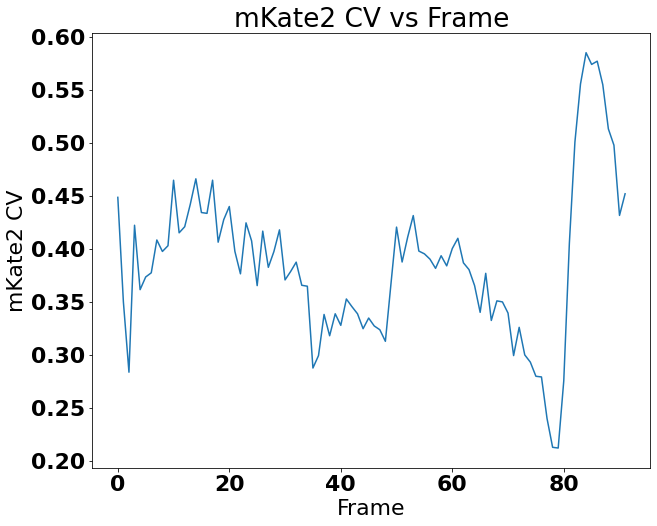

In [202]:
# Plot red CV noise
plt.figure(figsize=(10,8))
plt.plot(data['cv_red'])
plt.xlabel('Frame')
plt.ylabel('mKate2 CV')
plt.title('mKate2 CV vs Frame')

#### Example bar plot

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_38181/4017091453.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


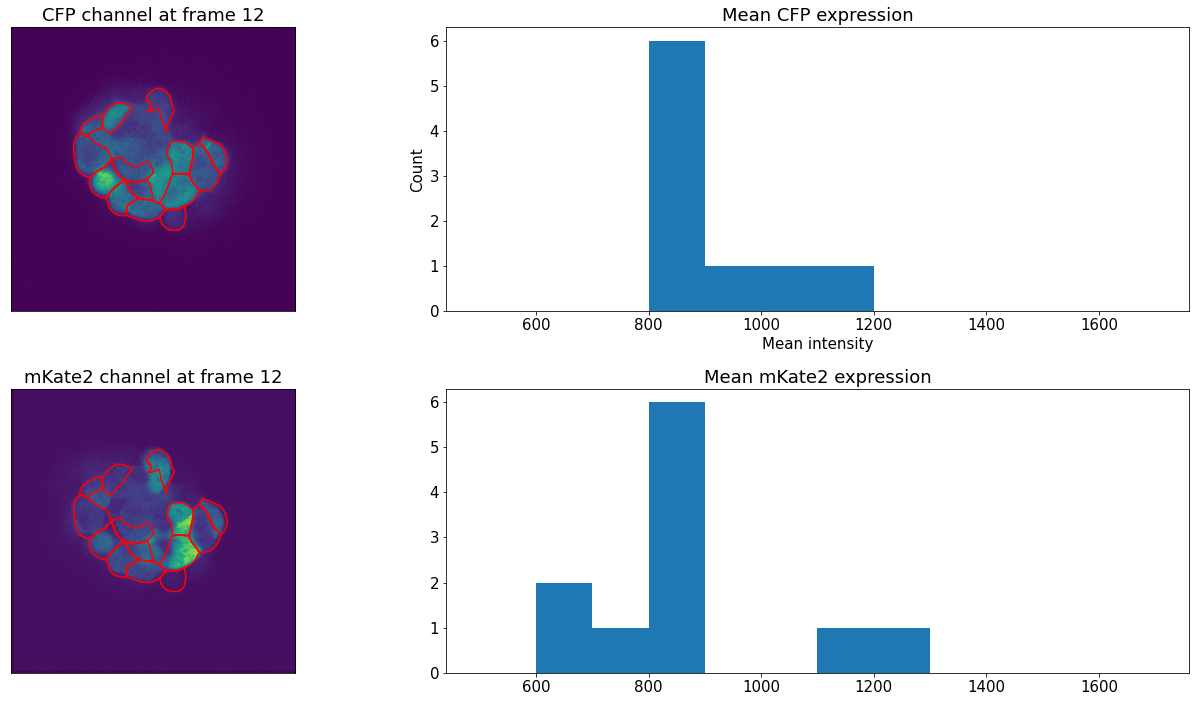

In [203]:
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from library import plots
from cellpose import plot, utils
def plot_cell_mean_hist(file, data):
    font = {
        'weight' : 'normal',
        'size'   : 15 
        }
    plt.rc('font', **font)

    dat_blue = np.load(f'blue/{file}_seg.npy', allow_pickle=True).item()
    dat_red = np.load(f'red/{file}_seg.npy', allow_pickle=True).item()
    # plot image with outlines overlaid in red
    img_blue = dat_blue['img']
    img_red = dat_red['img']
    outlines = utils.outlines_list(dat_blue['masks'])
    masked_imgs_blue = get_cell_masks(img_blue,outlines)
    means_blue = np.array([np.mean(get_pixel_intensities(img_blue, np.where(masked_img > 0))) for masked_img in masked_imgs_blue])

    masked_imgs_red = get_cell_masks(img_red,outlines)
    means_red = np.array([np.mean(get_pixel_intensities(img_red, np.where(masked_img > 0))) for masked_img in masked_imgs_red])

    # Exclude outliers in the data
    def reject_outliers(data, m=1):
        return data[abs(data - np.mean(data)) < m * np.std(data)]
    means_blue = reject_outliers(means_blue)
    means_red = reject_outliers(means_red)

    fig, axs = plt.subplots(2, 2,)
    fig.set_size_inches(20, 10)
    axs[0, 0].imshow(img_blue)
    axs[0, 0].set_title(f'CFP channel at frame {file}')
    axs[0, 0].set_yticks([])
    axs[0, 0].set_xticks([])
    for o in outlines:
        axs[0, 0].plot(o[:,0], o[:,1], color='r')

    axs[0, 1].hist(means_blue, bins = np.arange(500, data['max_limit']*.5 + 100, 100))
    axs[0, 1].set(xlabel='Mean intensity', ylabel='Mean CFP expression')
    axs[0, 1].set_title('Mean CFP expression')

    axs[1, 0].imshow(img_red)
    axs[1, 0].set_title(f'mKate2 channel at frame {file}')
    axs[1, 0].set_yticks([])
    axs[1, 0].set_xticks([])
    for o in outlines:
        axs[1, 0].plot(o[:,0], o[:,1], color='r')

    axs[1, 1].hist(means_red, np.arange(500, data['max_limit']*.5 + 100, 100))
    axs[0, 1].set(xlabel='Mean intensity', ylabel='Count')
    axs[1, 1].set_title('Mean mKate2 expression')

    fig.tight_layout()
    fig.show()

file = 12
data = {}
data['max_limit'] = max_limit
plot_cell_mean_hist(file, data)
# plots.create_gif()

In [204]:
name_of_file = 'plots/cell_mean_hist.gif'
plotting_function = plot_cell_mean_hist
data = {}
data['max_limit'] = max_limit
plots.create_gif(name_of_file, plotting_function, percent_of_side, red, data, no_images=True)

/var/folders/9m/qcg58ft12w72z4h1j7s196w00000gn/T/ipykernel_38181/4017091453.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
